In [1]:
#To generate a report about the consistency score of combined predicted data
#It also gives regions of interest, that could be good to resegment the data
#and test again with the Machine Learning

#To generate a pdf of this report, use the command line and type
#jupyter nbconvert --no-input --execute --to pdf GenerateReportAndAutoPointsOfInterest.ipynb

# This software requires leopardgecko.py and its dependencies
# For the pdf export to work it also needs the python packages
# nbconvert and nbformat
#and a TeX distribution
#https://nbconvert.readthedocs.io/en/latest/

import leopardgecko as lg
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# **Configuration Settings**

#Data weighing
dweightingmethod = 'MaxMinSquare'

#Average Pooling settings
w_avg = 512 #Chunks for the average pooling 3D using the GPU. Should not affect final data
k_width = 256
s_stride= 128

bForceRecalculation = False
# True: In case AvgPool of score data already exists, force recalculation
# False: Use existing file if it exists

mySegmentedVolumes = []

In [3]:
#Set data filename and location here


#Blood Vessel (placenta)
data_filename = '/workspace/for_luis/2020-04-09_final_4_volumes_combined.h5'
#Optional for plotting the score of the volume that was segmented manually
#Define what voluem was used in format (zmin,zmax , ymin,ymax , xmin,xmax )
#In don't want to define volume just make this =None
#mySegmentedVolumes.append( (900,1156 , 185,441 , 1750,2006) ) #This is the one that was used for teaching the neural network
mySegmentedVolumes.append( (897,1153 , 185,441 , 1750,2006) ) #Correction

mySegmentedVolumes.append( (512,768 , 1280,1536 , 1536,1792) )
mySegmentedVolumes.append( (0,256 , 1536,1792 , 1792,2048) )
mySegmentedVolumes.append( (0,256 , 1024,1280 , 512,768) )
mySegmentedVolumes.append( (1536,1792 , 256,512 , 0,256) )

#mySegmentedVolumes.append( (684,1068 , 2012,2396 , 457,841) )
mySegmentedVolumes.append( (684,1068 , 2012,2396 , 455,839) ) #Correction

#mySegmentedVolumes.append( (1067,1991 , 1074,1458 , 1354,1738) )
mySegmentedVolumes.append( (1067,1991 , 1074,1458 , 1352,1736) ) #Correction



#Maternal/foetal
#data_filename = '/workspace/for_luis/2020-05-15_final_4_volumes_combined.h5'
#mySegmentedVolume = (310,694 , 1242,1626 , 510,894 )

In [4]:
print ("Data filename : " , data_filename)
#Check if average pooling has already been done

Data filename :  /workspace/for_luis/2020-04-09_final_4_volumes_combined.h5


In [5]:
predicteddata_lg = lg.PredictedData(data_filename)

In [6]:
print("Shape: " , predicteddata_lg.data_da.shape )

Shape:  (2120, 2520, 2520)


In [7]:
#Get Maximum and minimum value
print ( "Values: max = {} , min = {} ".format(predicteddata_lg.vmax, predicteddata_lg.vmax) )

Values: max = 12 , min = 12 


# Consistency score (CS)

In [8]:
print ("Weighting data to get consistency score using method" ,dweightingmethod)

Weighting data to get consistency score using method MaxMinSquare


In [9]:
cs , cs_avg = predicteddata_lg.setWeightedData(dweightingmethod)

In [10]:
print("Consistency score whole volume average = {}".format(cs_avg))

Consistency score whole volume average = 32.36612531003841


In [11]:
cscore_segm = None
if len(mySegmentedVolumes)>0 :
    g =mySegmentedVolumes[0]
    cscore_segm = predicteddata_lg.getWeightedValueAverageOfVolume( g )
    print ("Manually segmented volume [ {}:{} , {}:{} , {}:{} ] has consistency score of {} .". \
      format( g[0], g[1] , g[2],g[3] , g[4],g[5] ,  cscore_segm) )

Manually segmented volume [ 897:1153 , 185:441 , 1750:2006 ] has consistency score of 34.89721089601517 .


# Average pooling of CS

Parameters used for average pooling

In [12]:
print("Sub-volume width : {}".format(k_width))
print("Stride (jump) : {}".format(s_stride))

Sub-volume width : 256
Stride (jump) : 128


In [13]:
#Decide here the filename of the file to store the avgpooled data
#If the file exists, then the calculation was probably been done before
# and existing file
#To override this and force recalculation (long) set flag ...

#Save file (locally, at the same folder as this notebook)
pathhead, pathtail = os.path.split(data_filename)
pathname , ext = os.path.splitext(pathtail)
newpathname = pathname + "_VolAvg_k" + str(k_width)+"_s"+str(s_stride)
newfilename = newpathname + '.h5'
print ("Consistency Score AvgPool3D data filename: ", newfilename)

Consistency Score AvgPool3D data filename:  2020-04-09_final_4_volumes_combined_VolAvg_k256_s128.h5


In [14]:
scoredata_lg = None

#Check file exists or if recalculation is intended
if ( os.path.exists(newfilename) and not bForceRecalculation) :
    print("File already exists, and recalculation is not required so the results in this file will be used")
    #Load data using leopardgecko ScoreData class
    scoredata_lg = lg.ScoreData.fromFile(newfilename)
    
else:
    #Calculate the AvgPool3D of the Consistency score
    scoredata_lg = predicteddata_lg.AvgPool3D_LargeData(w_avg , k_width , s_stride , do_weighting = False)
    scoredata_lg.saveToFile(newfilename)

File already exists, and recalculation is not required so the results in this file will be used


In [18]:
scoredata_lg.data3d.shape

(15, 18, 18)

# Histogram of Consistency score and regions-of-interest
Blue - Consistency score histogram \
red lines - points of interest \
green line -  consistency score for the region that was manually segmented

In [15]:
#Gets points of interest (see leopardgecko.py code to see how this was determined)
poi = scoredata_lg.SelectRegionsOfInterest_V1()

Gaussian fit to peak, parameters amplitude=336.99165968746934 , mean=33.27826868431828 ,stdev=0.842132052886519


In [16]:
#Prints a report about the locations of the points of interest
def point_ReportResultAs_Vol_Center_CScore(p3d , width):
    w2 = int(width/2)

    p = p3d[0] #First element is the voxel coordinates
    point_dist = p3d[1] #Second element is the distance to...
    point_cscore = p3d[2] #Second element is the consistency score

    s = "[ " + str(p[0]-w2) + ":" + str(p[0]+w2) + " , " + \
        str(p[1]-w2) + ":" + str(p[1]+w2) + " , " + \
        str(p[2]-w2) + ":" + str(p[2]+w2) + \
        " ]"
    s +=  " centered at " + str(p)
    s += " cscore=" + str(point_cscore)
    return s

for i in range( len(poi) ):
    print ("P{}".format(i) , point_ReportResultAs_Vol_Center_CScore( poi[i] , k_width) )

P0 [ 1792:2048 , 1536:1792 , 128:384 ] centered at (1920, 1664, 256) cscore=20.512474536895752
P1 [ 1792:2048 , 1664:1920 , 128:384 ] centered at (1920, 1792, 256) cscore=25.616242706775665
P2 [ 640:896 , 640:896 , 1024:1280 ] centered at (768, 768, 1152) cscore=30.682079195976257
P3 [ 640:896 , 1152:1408 , 768:1024 ] centered at (768, 1280, 896) cscore=31.506973445415497
P4 [ 640:896 , 1152:1408 , 1024:1280 ] centered at (768, 1280, 1152) cscore=32.287492752075195
P5 [ 768:1024 , 1024:1280 , 1152:1408 ] centered at (896, 1152, 1280) cscore=32.877247393131256
P6 [ 768:1024 , 896:1152 , 1024:1280 ] centered at (896, 1024, 1152) cscore=33.244472205638885


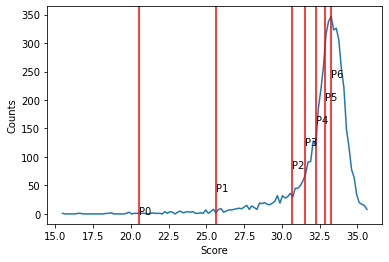

In [17]:
#Plots the Consistency score histogram and highlights points of interest
plt.plot(scoredata_lg.histogram_bins, scoredata_lg.histogram)
plt.xlabel('Score')
plt.ylabel('Counts')

for i in range( len(poi) ):
    x0 = poi[i][2]
    #gets the point score
    #This is one of the nice things about the routine that gets the points of interest
    #it returns a tuple with the locations, distance and score
    
    plt.axvline( x0, color='red')

    #Annotate lines
    #plt.annotate( 'P{}'.format(i), ( x0, fgaussian(x0, popt[0], popt[1], popt[2]) ) )
    plt.annotate( 'P{}'.format(i), ( x0, i*40 ) )
    #uses the gaussian approximation to get a rough location of the point

In [18]:
#In case leopardgecko.py has been modified, run these commands bellow
#import importlib
#importlib.reload(lg)

# Manually segmented volumes - CS

V0 [ 897:1153 , 185:441 , 1750:2006 ] , consistency score of 34.89721089601517
V1 [ 512:768 , 1280:1536 , 1536:1792 ] , consistency score of 34.19626897573471
V2 [ 0:256 , 1536:1792 , 1792:2048 ] , consistency score of 33.13370609283447
V3 [ 0:256 , 1024:1280 , 512:768 ] , consistency score of 34.22354298830032
V4 [ 1536:1792 , 256:512 , 0:256 ] , consistency score of 29.879499673843384
V5 [ 684:1068 , 2012:2396 , 455:839 ] , consistency score of 33.61268769370185
V6 [ 1067:1991 , 1074:1458 , 1352:1736 ] , consistency score of 33.33952846040859


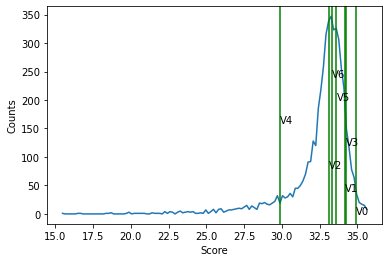

In [19]:
#Create a new histogram with the pre-segmented volume scores highlighted
plt.plot(scoredata_lg.histogram_bins, scoredata_lg.histogram)
plt.xlabel('Score')
plt.ylabel('Counts')

hmax = np.amax(scoredata_lg.histogram)

for i in range( len(mySegmentedVolumes) ):
    #For each of the segmented volumes, calculates the Consistency Score
    g =mySegmentedVolumes[i]
    cscore_segm = predicteddata_lg.getWeightedValueAverageOfVolume( g )
    plt.axvline( cscore_segm , color='green')
    #plt.annotate("V{}".format(i) , (cscore_segm , (hmax / predicteddata_lg.vmax * cscore_segm) ) )
    plt.annotate("V{}".format(i) , (cscore_segm , i*40 ) )
    
    print ("V{} [ {}:{} , {}:{} , {}:{} ] , consistency score of {}". \
      format( i, g[0], g[1] , g[2],g[3] , g[4],g[5] ,  cscore_segm) )
#plt.show()